# [The spelled-out intro to neural networks and backpropagation: building micrograd](https://www.youtube.com/watch?v=VMj-3S1tku0)
### by Andrej Karpathy

I should be able to rebuild this myself.  
this is a great teaching tool.

In [17]:
import math
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline

In [18]:
xs = np.arange(-5,5,0.25)
ys = f(xs)
plt.plot(xs,ys)

NameError: name 'f' is not defined

In [19]:
class Value:
    
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label
        
    def __repr__(self):
        return f"Value(data={self.data})"

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')
        
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward    
            
        return out
    
    def __radd__(self, other):
            return self * other

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')
        
        def _backward():
            self.grad = out.grad * other.data
            other.grad = out.grad * self.data
        out._backward = _backward
        
        return out
    
    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int & float powers for now"
        out = Value(self.data**other, (self,),f'**{other}')

        def _backward():
            self.grad += other * self.data ** (other-1) * out.grad
        out._backward = _backward
        
        return out
    
    
    def __rmul__(self, other):
        return self * other
    
    def __truediv__(self, other):
        return self * other ** -1
    
    def __neg__(self):
        return self * -1
    
    def __sub__(self, other):
        return self + (-other)
    
    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Value(t, (self, ), 'tanh')
        
        def _backward():
            self.grad = (1-t**2) * out.grad
        out._backward = _backward
        
        return out
    
    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')
    
        def _backward():
            self.grad += out.data * out.grad
        out._backward = _backward
        
        return out
    
    def backward(self):
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)
        
        self.grad = 1.0
        for node in reversed(topo):
            node._backward()

In [20]:
a = Value(2.0)
b = Value(4.0)
a - b

Value(data=-2.0)

In [21]:
def manual_gradient():
    h = 0.0001
    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a*b; e.label = 'e'
    d = e + c; d.label = 'd'
    f = Value(-2.0, label='f')
    L = d * f; L.label = 'L'
    L1 = L.data
    
    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    b.data += h
    c = Value(10.0, label='c')
    e = a*b; e.label = 'e'
    d = e + c; d.label = 'd'
    f = Value(-2.0, label='f')
    L = d * f; L.label = 'L'
    L2 = L.data
    
    print((L2-L1)/h)
    
manual_gradient()

-4.000000000008441


In [46]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    print(n)
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

In [47]:
# inputs
x1 = Value(2.0, label = 'x1')
x2 = Value(0.0, label = 'x2')

# weights
w1 = Value(-3.0, label = 'w1')
w2 = Value(1.0, label = 'w2')

# bias
b = Value(6.8813735870195432, label = 'b')

# x1w1 + x2w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1+x2w2'
n = x1w1x2w2 + b; n.label = 'n'
# --- manual implementation of tanh
e = (2*n).exp()
o = (e - 1) / (e + 1)
# ---
o.label = 'o'
o.backward()

Value(data=0.8813735870195432)
Value(data=-6.0)
Value(data=0.0)
Value(data=6.828427124746192)
Value(data=1.7627471740390863)
Value(data=0.1464466094067262)
Value(data=1)
Value(data=0.0)
Value(data=-3.0)
Value(data=5.828427124746192)
Value(data=6.881373587019543)
Value(data=2)
Value(data=-1)
Value(data=-6.0)
Value(data=4.828427124746192)
Value(data=0.7071067811865477)
Value(data=2.0)
Value(data=1.0)


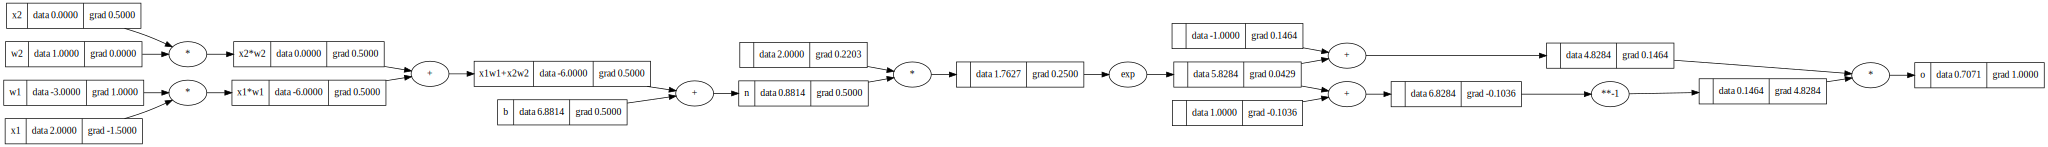

In [48]:
draw_dot(o)

In [49]:
import torch

In [50]:
x1 = torch.Tensor([2.0]).double()                ; x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()                ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()               ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()                ; w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double()  ; b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('---')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

0.7071066904050358
---
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


In [51]:
torch.Tensor([[1,2,3],[4,5,6]]).shape

torch.Size([2, 3])

In [166]:
class Neuron:
    def __init__(self, nin):
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1,1))
        
    def __call__(self, x):
        act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
        out = act.tanh()
        return out
    
    def parameters(self):
        return self.w + [self.b]
    
class Layer:
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]
        
    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs
        
    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]

class MLP:
    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
    
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

In [168]:
x = [2.0, 3.0, -1.0]
n = MLP(3, [4,4,1])
n(x)

Value(data=-0.5198464990913285)

In [181]:
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0]
]
ys = [1.0, -1.0, -1.0, 1.0]
ypred = [n(x) for x in xs]

In [182]:
for k in range(100):
    # forward
    ypred = [n(x) for x in xs]
    loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))

    # backward
    for p in n.parameters():
        p.grad = 0.0
    loss.backward()
    
    # update
    for p in n.parameters():
        p.data += -0.05 * p.grad
        
    print(k, loss.data)

0 0.002790423204194392
1 0.002786566628053792
2 0.00277641871839474
3 0.0027718719178297197
4 0.002764399097481614
5 0.0027585455152441384
6 0.002757625128603315
7 0.0027535673883785526
8 0.0027524079692614126
9 0.002744944700639664
10 0.0027412104970781703
11 0.002737485171166904
12 0.0027317789805792287
13 0.002730628469843714
14 0.0027210428408386404
15 0.0027199139468422505
16 0.0027163139894078696
17 0.0027127178470595405
18 0.0027042641854673035
19 0.0027007743549959484
20 0.0026950537009732
21 0.0026908594065072344
22 0.002687404832363276
23 0.002684068195591264
24 0.0026799102310993694
25 0.002678851617577507
26 0.0026779811183543236
27 0.002670892365765603
28 0.002667705002947227
29 0.0026595369570746033
30 0.002655462183695928
31 0.00265210347082383
32 0.0026478539201436604
33 0.00264355188314904
34 0.0026366548873683763
35 0.0026326314827512807
36 0.0026272400497946227
37 0.002623630654762757
38 0.0026194213717295432
39 0.002618099545636951
40 0.0026149522880518352
41 0.0026

In [180]:
ypred

[Value(data=0.9560178864999122),
 Value(data=-0.9712867321124085),
 Value(data=-0.9833350166631004),
 Value(data=0.9587971320983891)]